In [ ]:
import os
import zipfile

# Create Kaggle directory and move kaggle.json
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jiayuanchengala/aid-scene-classification-datasets

Dataset URL: https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets
License(s): CC0-1.0
100% 2.44G/2.45G [00:16<00:00, 161MB/s]
100% 2.45G/2.45G [00:16<00:00, 163MB/s]


In [ ]:
# Unzip it
with zipfile.ZipFile("aid-scene-classification-datasets.zip", 'r') as zip_ref:
    zip_ref.extractall("aid_scene_classification")

# Show path
print("Dataset extracted to:", os.path.abspath("aid_scene_classification"))

Dataset extracted to: /content/aid_scene_classification


In [ ]:
!pip install tensorflow pillow numpy opencv-python tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


# Parameters
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
NUM_CLASSES = 30  # AID has 30 scene classes
EPOCHS = 25

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)
train_gen = train_datagen.flow_from_directory(
    '/content/aid_scene_classification/AID',  # root directory with class subfolders
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_gen = train_datagen.flow_from_directory(
    '/content/aid_scene_classification/AID',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Build and fine-tune the model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers for transfer learning, then unfreeze for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Transfer learning
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# Fine-tuning: unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS-5
)

model.save('satellite_model_2.h5')

Found 8000 images belonging to 30 classes.
Found 2000 images belonging to 30 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.0468 - loss: 3.4121 - val_accuracy: 0.0515 - val_loss: 3.2830
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.0639 - loss: 3.3100 - val_accuracy: 0.0885 - val_loss: 3.2329
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.0608 - loss: 3.2824 - val_accuracy: 0.0740 - val_loss: 3.2118
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.0678 - loss: 3.2616 - val_accuracy: 0.0835 - val_loss: 3.1903
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.0752 - loss: 3.2483 - val_accuracy: 0.0780 - val_loss: 3.1555
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.3693 - loss: 2.3378 - val_accuracy: 0.0295 - val_loss: 7.0555
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.8987 - loss: 0.3571 - val_accuracy: 0.0880 - val_loss: 6.0724
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.9444 - loss: 0.1975 - val_accuracy:

In [ ]:
# Freeze base layers for transfer learning, then unfreeze for fine-tuning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Transfer learning
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

In [ ]:
# Fine-tuning: unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS-5
)

model.save('satellite_model_2.h5')

In [ ]:
import numpy as np
from PIL import Image
from tqdm import tqdm

def classify_large_image(image_path, model, tile_size=300, stride=300):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    h, w, _ = img_np.shape
    result_map = np.zeros((h // stride, w // stride), dtype=int)
    for i, y in enumerate(tqdm(range(0, h - tile_size + 1, stride))):
        for j, x in enumerate(range(0, w - tile_size + 1, stride)):
            patch = img_np[y:y+tile_size, x:x+tile_size, :]
            patch_img = Image.fromarray(patch).resize(IMG_SIZE)
            patch_arr = np.array(patch_img) / 255.0
            patch_arr = np.expand_dims(patch_arr, axis=0)
            pred = model.predict(patch_arr, verbose=0)
            result_map[i, j] = np.argmax(pred)
    return result_map

# Usage example:
model = tf.keras.models.load_model('/content/satellite_model.h5')
result_map = classify_large_image('/content/stitched_satellite_image.png', model)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (110166016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 34/34 [01:52<00:00,  3.31s/it]


[[ 9  9 11 ... 11 10 11]
 [13  9  9 ... 11 13 11]
 [ 9  9  9 ... 11 11 11]
 ...
 [11 11 11 ... 11 10 28]
 [11 11 11 ... 28 11 10]
 [11 11  9 ... 28 28 28]]
Tile (0,0) predicted as: Desert


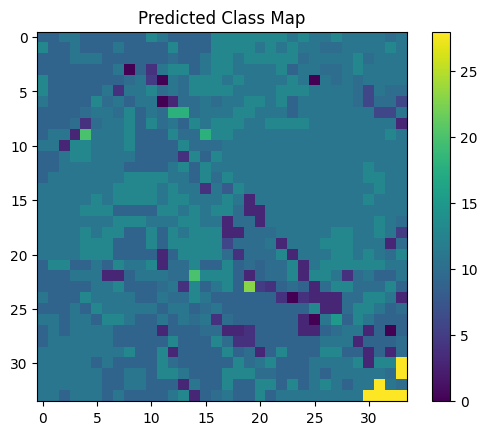

In [ ]:
# result_map is a 2D numpy array of class indices
print(result_map)  # Shows the predicted class index for each tile

# To map indices to class names:
class_names = list(train_gen.class_indices.keys())  # If you used ImageDataGenerator
# Or, if you have a list of class names:
# class_names = ['airport', 'bareland', 'beach', ..., 'viaduct']

# Example: print class name for tile (0,0)
print("Tile (0,0) predicted as:", class_names[result_map[0,0]])

# To visualize the result as an image (optional):
import matplotlib.pyplot as plt
plt.imshow(result_map)
plt.colorbar()
plt.title("Predicted Class Map")
plt.show()

In [ ]:
import cv2
import numpy as np
from PIL import Image

def draw_patch_boxes_on_image(image_path, result_map, class_names, tile_size=300, stride=300, output_path='output_with_boxes.png'):
    img = np.array(Image.open(image_path).convert('RGB'))
    h, w, _ = img.shape
    img_draw = img.copy()

    for i in range(result_map.shape[0]):
        for j in range(result_map.shape[1]):
            y = i * stride
            x = j * stride
            class_idx = result_map[i, j]
            class_label = class_names[class_idx]
            # Draw rectangle
            cv2.rectangle(img_draw, (x, y), (x+tile_size, y+tile_size), (0, 255, 0), 2)
            # Put class label
            cv2.putText(img_draw, class_label, (x+5, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    # Save or display
    Image.fromarray(img_draw).save(output_path)
    print(f"Saved result to {output_path}")

# Usage example after running classify_large_image:
class_names = list(train_gen.class_indices.keys())
draw_patch_boxes_on_image('/content/stitched_satellite_image.png', result_map, class_names, tile_size=300, stride=300)


Saved result to output_with_boxes.png
